# Mad7 article Data analysis and figures
This document walks through the steps of retrieving and analysing the raw data and generating the figures for the paper  
This has been tested on Ubuntu 20.04 but I expect it will run on any linux with an appropriatly setup environment  
This can most likely also run on windows/mac but there are a few places where we are running terminal commands (lines starting with exclamation mark) which are probably linux specific and would need to be changed to win/mac equivalents.
  
### External tools that need to be available in PATH:
* git, wget, gunzip  # Usually installed via your distribution package manager
* rust  # Can be obtained here: https://www.rust-lang.org/learn/get-started
* flash  # Can be obtained here: http://ccb.jhu.edu/software/FLASH/  

### Python setup
* python3.9 (probably works with any python >= 3.6) 
* pandas (tested 1.2.3)
* matplotlib (tested 3.4.0)
* biopython (tested 1.78)
* jupyterlab (tested 3.0.12)
* openpyxl (tested 3.0.7)

In [1]:
! pip install -U pandas matplotlib biopython openpyxl

     |████████████████████████████████| 10.3 MB 2.8 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4


In [1]:
import pandas as pd                              # using pandas to read the data
from collections import defaultdict
from matplotlib import pyplot as plt             # matplotlib pyplot for some convenience drawing functions
from matplotlib.ticker import PercentFormatter   # formatting of y axis
from matplotlib.patches import Patch             # for creating the legend
from Bio import SeqIO                            # We're gonna work with fasta and genbank files
from Bio.Seq import reverse_complement           # And we're going to be reverse complementing sequences

### We will also need to download hamplicons

In [2]:
! git clone https://github.com/laeblab/hamplicons
! pip install ./hamplicons

Cloning into 'hamplicons'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 79 (delta 30), reused 70 (delta 27), pack-reused 0
Unpacking objects: 100% (79/79), 24.72 KiB | 356.00 KiB/s, done.
Processing ./hamplicons
  Using cached coloredlogs-10.0-py2.py3-none-any.whl (47 kB)
  Using cached XlsxWriter-1.1.4-py2.py3-none-any.whl (142 kB)
  Using cached humanfriendly-9.1-py2.py3-none-any.whl (86 kB)
  Created wheel for hamplicons: filename=hamplicons-4.1.1-py3-none-any.whl size=9914 sha256=e0a2665beffaad3354131098cece796a854b0d9446e3c686df02ad7ddcd375f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-8ysemzcs/wheels/4b/c4/0b/d364e94bdf3615ec3129fe5e51ada1299db1e0e87d562618d1
Successfully built hamplicons


### And were going to need CRISPyR

In [3]:
! git clone https://github.com/laeblab/crispy.git
! cd crispy && cargo build --release

Cloning into 'crispy'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 183 (delta 52), reused 69 (delta 32), pack-reused 80
Receiving objects: 100% (183/183), 86.79 KiB | 1.77 MiB/s, done.
Resolving deltas: 100% (75/75), done.
   Compiling libc v0.2.71
   Compiling proc-macro2 v1.0.5
   Compiling unicode-xid v0.2.0
   Compiling syn v1.0.5
   Compiling lazy_static v1.4.0
   Compiling cfg-if v0.1.10
   Compiling autocfg v0.1.6
   Compiling memchr v2.2.1
   Compiling serde v1.0.101                                         ] 0/144
   Compiling semver-parser v0.7.0                                   ] 1/144
   Compiling byteorder v1.3.2                                       ] 2/144
   Compiling getrandom v0.1.14                                      ] 3/144
   Compiling arrayvec v0.4.12                                       ] 4/144
   Compiling cc v1.0.45                                    

# First we designed gRNAs with CRISPyR  
Now the following written steps are what we actually did, but in order to prevent updates to genome/annotation/CRISPyR from messing with the data analysis, the code doesnt reflect our original steps, but rather a "frozen" version of the results.  
These are the real steps to take:
1. Download a CHO genome fasta and gff
2. Generate a CRISPyR index of the CHO genome
3. Use the gff file to find exons of the genes we want to KO and generate fasta file with all exons
4. Use CRISPyR to find Mad7+Cas9 targets and pick some
5. Generate PCR primers to be used to analyse edits  
  
As mentioned above, the following code here will simply fetch the genome fasta from NCBI and the PCR primers from GBEX and then create a fasta file with the amplicons for use with "hamplicons" and also a demonstration of how to use CRISPyR.

### 1 Download a CHO genome fasta and gff

In [4]:
! mkdir cho_genome
#! wget -P cho_genome ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/003/668/045/GCF_003668045.3_CriGri-PICRH-1.0/GCF_003668045.3_CriGri-PICRH-1.0_genomic.fna.gz
! wget -P cho_genome https://ftp.ncbi.nlm.nih.gov/genomes/refseq/vertebrate_mammalian/Cricetulus_griseus/latest_assembly_versions/GCF_000223135.1_CriGri_1.0/GCF_000223135.1_CriGri_1.0_genomic.fna.gz
! gunzip cho_genome/*.gz

--2021-03-29 10:38:52--  https://ftp.ncbi.nlm.nih.gov/genomes/refseq/vertebrate_mammalian/Cricetulus_griseus/latest_assembly_versions/GCF_000223135.1_CriGri_1.0/GCF_000223135.1_CriGri_1.0_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.230, 130.14.250.10, 2607:f220:41e:250::7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 742973849 (709M) [application/x-gzip]
Saving to: ‘cho_genome/GCF_000223135.1_CriGri_1.0_genomic.fna.gz’

GCF_000223135.1_Cri 100%[===================>] 708,55M  14,2MB/s    in 52s     

2021-03-29 10:39:45 (13,6 MB/s) - ‘cho_genome/GCF_000223135.1_CriGri_1.0_genomic.fna.gz’ saved [742973849/742973849]



### 2 Load the PCR primers

In [5]:
# MAKE SURE TO POINT THIS TO WHERE YOU ACTUALLY GOT Oligos.tsv
oligo_df = pd.read_csv("Oligos.tsv", sep='\t')

pcr_primer_sets = defaultdict(dict)  # for storing primersets

fwd_miseq = "TCGTCGGCAGCGTCAGATGTGTATAAGAGACAG"  # illumina overhang part of primers
rev_miseq = "GTCTCGTGGGCTCGGAGATGTGTATAAGAGACAG" # illumina overhang part of primers

for _, oligo in oligo_df.iterrows():
     if oligo['type'] == 'PCR primer':
        name_parts = oligo['name'].split(" ")
        set_name = name_parts[-2]
        dir_name = name_parts[-1]
        if dir_name == 'Fwd':
            seq = oligo['sequence'][len(fwd_miseq):]
        else:
            seq = oligo['sequence'][len(rev_miseq):]
        pcr_primer_sets[set_name][dir_name] = seq

In [6]:
pcr_primer_sets

defaultdict(dict,
            {'#1': {'Fwd': 'CTCTGCTGCCTCCTAGTCATCC',
              'Rev': 'GAGCCTGAAGCCTCCTCATCAT'},
             '#2': {'Fwd': 'AGGGCTTCTGGGACTTCACTTT',
              'Rev': 'TTAGTAGGGGCTCCTAGGCAGG'},
             '#3': {'Fwd': 'CAGTTGGGCTGGGGATCAACTA',
              'Rev': 'CAGAAAGGGGGCTAGACTCACC'},
             '#4': {'Fwd': 'GCTGTCTCTATTAGAATTATGCTTG',
              'Rev': 'GGAGGGAGACAGGGAAAGAG'},
             '#5': {'Fwd': 'TTGGAGTCAAGAGGGCCTACTA',
              'Rev': 'CCATGGTGGCTACTACTGCTTT'},
             '#6': {'Fwd': 'TTATCTTCAGGCTTGGCTTAGG',
              'Rev': 'CTCTCACCTGGAGGAGCTTG'},
             '#7': {'Fwd': 'CCTGGTAGAGCTACGAATCCAT',
              'Rev': 'CTTCATCGTGTCCTGAAACAAA'},
             '#8': {'Fwd': 'AAATGAGGCAGGTCATAGGGTA',
              'Rev': 'GAGTTCTCGTAGGGTAGGCAGA'},
             '#9': {'Fwd': 'CAGATGCTCAAAGGATTCGAC',
              'Rev': 'CAGGAAGCATCTGAGGATGAA'},
             '#10': {'Fwd': 'AATGGAAGTTTGCACATCAGTG',
              'Rev': '

### 3 Extract amplicons from genome sequence

In [7]:
for rec in SeqIO.parse("cho_genome/GCF_000223135.1_CriGri_1.0_genomic.fna", format='fasta'):
    # now this ought to run through all contigs, but that takes a long time and I happen to know where all the amplicons are located =)
    if rec.name not in ['NW_003614255.1', 'NW_003615404.1']:
        continue
    print(rec.name)
    myrec = rec
    found = False
    for name, primer_set in pcr_primer_sets.items():
        fwd_pos = rec.seq.upper().find(primer_set['Fwd'])
        if fwd_pos != -1:
            rev_pos = rec.seq.upper().find(reverse_complement(primer_set['Rev']))
            if rev_pos != -1:
                print(name)
                found = True
                pcr_primer_sets[name]['amp'] = rec.seq.upper()[fwd_pos:rev_pos+len(primer_set['Rev'])]
        if not found:  # try reverse complement
            fwd_pos = rec.seq.upper().find(reverse_complement(primer_set['Fwd']))
            if fwd_pos != -1:
                rev_pos = rec.seq.upper().find(primer_set['Rev'])
                if rev_pos != -1:
                    print(name)
                    pcr_primer_sets[name]['amp'] = reverse_complement(rec.seq.upper()[rev_pos:fwd_pos+len(primer_set['Fwd'])])

NW_003614255.1
#1
#2
#5
#6
#7
#8
NW_003615404.1
#3
#4
#9
#10
#11


In [8]:
pcr_primer_sets

defaultdict(dict,
            {'#1': {'Fwd': 'CTCTGCTGCCTCCTAGTCATCC',
              'Rev': 'GAGCCTGAAGCCTCCTCATCAT',
              'amp': Seq('CTCTGCTGCCTCCTAGTCATCCATTGTGAGGGATAGGAAAACAGTGCCAACACA...CTC')},
             '#2': {'Fwd': 'AGGGCTTCTGGGACTTCACTTT',
              'Rev': 'TTAGTAGGGGCTCCTAGGCAGG',
              'amp': Seq('AGGGCTTCTGGGACTTCACTTTGGATGATGGGCTGCTCATGATGCATGATGAGG...TAA')},
             '#3': {'Fwd': 'CAGTTGGGCTGGGGATCAACTA',
              'Rev': 'CAGAAAGGGGGCTAGACTCACC',
              'amp': Seq('CAGTTGGGCTGGGGATCAACTACTACCTTGTCTCTCCCAGCAGATACCACTATG...CTG')},
             '#4': {'Fwd': 'GCTGTCTCTATTAGAATTATGCTTG',
              'Rev': 'GGAGGGAGACAGGGAAAGAG',
              'amp': Seq('GCTGTCTCTATTAGAATTATGCTTGTATATATGTTTTGCTGTTATGGGTTCATG...TCC')},
             '#5': {'Fwd': 'TTGGAGTCAAGAGGGCCTACTA',
              'Rev': 'CCATGGTGGCTACTACTGCTTT',
              'amp': Seq('TTGGAGTCAAGAGGGCCTACTATAATGGCATCAGCCTCTTCAACAACCCTGTGG...TGG')},
             '#6': {'Fwd':

In [9]:
# Writing to file
with open('targets.fa', 'w') as f:
    for name, primer_set in pcr_primer_sets.items():
        f.write(f">{name}\n")
        f.write(f"{primer_set['amp']}\n")

### 4 Generate a CRISPyR index of the CHO genome and find Mad7 gRNA sites in the amplicons

In [10]:
! ./crispy/target/release/crispyr index --enzyme mad7 cho_genome/GCF_000223135.1_CriGri_1.0_genomic.fna

Finding targets in "cho_genome/GCF_000223135.1_CriGri_1.0_genomic.fna"
Finding target sites in "cho_genome/GCF_000223135.1_CriGri_1.0_genomic.fna"
  Processed 2393 Mbp in 175 seconds (13.7 Mbp/s)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [11]:
# Find mad7 grnas
! ./crispy/target/release/crispyr find cho_genome/GCF_000223135.1_CriGri_1.0_genomic.fna.crispyr_mad7 targets.fa > mad7_gRNAs.tsv


Reading K-mers from "cho_genome/GCF_000223135.1_CriGri_1.0_genomic.fna.crispyr_mad7"
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ [0s elapsed; 13s left]
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ [0s elapsed; 13s left]
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ [0s elapsed; 11s left]
█░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ [0s elapsed; 8s left]
██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ [0s elapsed; 7s left]
██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ [0s elapsed; 7s left]
███░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ [0s elapsed; 6s left]
████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ [0s elapsed; 6s left]
████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ [0s elapsed; 6s left]
█████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ [0s elapsed; 6s left]
██████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ [0s elapsed; 6s left]
███████░░░░░░░░░░░░░░░░░░░░░░░░░░░

Now if you look in the mad7_gRNAs.tsv that CRISPyR has generated, you will find that some identical sequences has been found for multiple targets.
In this case, this is because we submitted overlapping amplicons to CRISPyR.
CRISPyR just goes through each target and treat them as independent targets.

We picked the following gRNAs:
* BGN-gRNA1: TTCAAAGGGCAGGGCCTGGCT
* BGN-gRNA2: AACAAAAGGGCTTCTGGGACT
* BGN-gRNA3: GATGATGGGCTGCTCATGATG
* BGN-gRNA4: GGCTGCCACTGCCACCTGAGG
* Timp1-gRNA1: CATCTCTGGCCTCAGGCATCC
* Timp1-gRNA2: TGGGGGCCCCATGAATTTAGC
* Timp1-gRNA3: CAACTTATACCAACGTTATGA
* Timp1-gRNA4: AACTTATACCAACGTTATGAG

# Then handle the NGS data

### 1 Analysis with hamplicons
Hamplicons runs a hamming distance analysis on amplicons to attempt to bin them to particular PCR products (amplicons).  
The size of the amplicons is then compared to that of the expected distance.  
The input for hamplicons is the fastq files from NGS and the amplicon targets fasta file 
If you look at the output you will notice it also identifies some products not present in the targets fasta file. This is because we share runs on our NGS machine with other projects.

In [12]:
## Make sure to point hamplicon to your fastq directory

In [24]:
! mkdir -p hamp_out
#! python hamplicons/hamplicons.py -dd some/path/fastq -dd-recursive hamp_out/run
! hamplicons -dd Fastqs/run1 --data-directory-recursive hamp_out/run1

11:11:06 - Reading FASTA file 'targets.fa'
11:11:06 - Name   Length   5p Ham   3p Ham
11:11:06 - #1       223        4        4
11:11:06 - #10      162        4        4
11:11:06 - #11      157        4        4
11:11:06 - #2       247        4        4
11:11:06 - #3       193        4        4
11:11:06 - #4       250        4        4
11:11:06 - #5       155        4        4
11:11:06 - #6       156        4        4
11:11:06 - #7       197        4        4
11:11:06 - #8       152        4        4
11:11:06 - #9       185        4        4
11:11:06 - Locating FASTQ files in Fastqs/run1
11:11:06 - Identified 268 FASTQ file pairs
11:11:06 - Merging FASTQ files
11:11:07 - Sample 002 merged in 1.0 seconds
11:11:07 - Sample 001 merged in 1.3 seconds
11:11:07 - Sample 003 merged in 1.4 seconds
11:11:08 - Sample 005 merged in 1.6 seconds
11:11:08 - Sample 006 merged in 1.8 seconds
11:11:08 - Sample 004 merged in 1.8 seconds
11:11:08 - Sample 008 merged in 2.3 seconds
11:11:09 - Sample 009 m

In [25]:
# Unfortunately the Cas9 RNP samples failed in the first run, and were repeated
! hamplicons -dd Fastqs/run2_rerun_of_cas9_chos --data-directory-recursive hamp_out/run2

11:12:26 - Reading FASTA file 'targets.fa'
11:12:26 - Name   Length   5p Ham   3p Ham
11:12:26 - #1       223        4        4
11:12:26 - #10      162        4        4
11:12:26 - #11      157        4        4
11:12:26 - #2       247        4        4
11:12:26 - #3       193        4        4
11:12:26 - #4       250        4        4
11:12:26 - #5       155        4        4
11:12:26 - #6       156        4        4
11:12:26 - #7       197        4        4
11:12:26 - #8       152        4        4
11:12:26 - #9       185        4        4
11:12:26 - Locating FASTQ files in Fastqs/run2_rerun_of_cas9_chos
11:12:26 - Identified 64 FASTQ file pairs
11:12:26 - Merging FASTQ files
11:12:36 - Sample 005 merged in 10.1 seconds
11:12:37 - Sample 004 merged in 11.6 seconds
11:12:39 - Sample 008 merged in 13.5 seconds
11:12:40 - Sample 003 merged in 14.8 seconds
11:12:42 - Sample 007 merged in 15.9 seconds
11:12:43 - Sample 006 merged in 17.1 seconds
11:12:47 - Sample 001 merged in 21.4 second

### 2 Fiddle around with dataframes to make it easy to use

In [2]:
run1_setup = pd.read_csv('run1_setup.tsv', sep='\t')  # make sure to point to actual run setup locations
run2_setup = pd.read_csv('run2_setup.tsv', sep='\t')  # make sure to point to actual run setup locations

# load hamplicon output data
data1 = pd.read_excel('hamp_out/run1.xlsx', sheet_name='results', engine="openpyxl")  # read hamplicons output
data1 = data1[data1.columns[:7]] # we only use the first 7 columns
data1 = data1[data1['Reads'] > 200]  # filter out low reads wells. Most likely just a drop that fell into a wrong well
data1['%Indel'] = data1['Indel']/data1['Reads']  # when opened in excel, an automatic recalculation of all cells is usually done, but going directly to python, it may not be so
# repeat for rerun
data2 = pd.read_excel('hamp_out/run2.xlsx', sheet_name='results', engine="openpyxl")  # read hamplicons output
data2 = data2[data2.columns[:7]] # we only use the first 7 columns
data2 = data2[data2['Reads'] > 200]  # filter out low reads wells. Most likely just a drop that fell into a wrong well
data2['%Indel'] = data2['Indel']/data2['Reads']  # when opened in excel, an automatic recalculation of all cells is usually done, but going directly to python, it may not be so

In [3]:
# check if amplicons detected match experimental setup
print("checking run1")
for i in range(run1_setup.mindex.max()):
    #amps detected vs amps expected
    amps_not_expected = set(data1[data1['Index/Well'] == i]['Target'])-set(run1_setup[run1_setup.mindex == i].amp)
    amps_not_detected = set(run1_setup[run1_setup.mindex == i].amp)-set(data1[data1['Index/Well'] == i]['Target'])
    if amps_not_detected:
        print(f"Did not detect amp '{amps_not_detected}' in index '{i}'")
    if amps_not_expected:
        print(f"Did not expect amp '{amps_not_expected}' in index '{i}'")
        
# check if amplicons detected match experimental setup
print("checking run2")
for i in range(run2_setup.mindex.max()):
    #amps detected vs amps expected
    amps_not_expected = set(data2[data2['Index/Well'] == i]['Target'])-set(run2_setup[run2_setup.mindex == i].amp)
    amps_not_detected = set(run2_setup[run2_setup.mindex == i].amp)-set(data2[data2['Index/Well'] == i]['Target'])
    if amps_not_detected:
        print(f"Did not detect amp '{amps_not_detected}' in index '{i}'")
    if amps_not_expected:
        print(f"Did not expect amp '{amps_not_expected}' in index '{i}'")

checking run1
Did not expect amp '{'#6'}' in index '62'
Did not expect amp '{'#6'}' in index '63'
Did not expect amp '{'#4'}' in index '86'
Did not expect amp '{'#4'}' in index '87'
Did not expect amp '{'#4'}' in index '88'
Did not detect amp '{'#3', '#10'}' in index '182'
checking run2


In [4]:
# It appears that we made 5 pipetting mistakes. And missed Index 182 completely
# Index 182 should have two controls:
# PTN1, with Cas9+gRNA but without electroporation
# CHO-S WT on amplicon #10
# Luckily we have multiple other controls that cover the same

# now lets join the 2 dataframes
df = pd.merge(run1_setup, data1, how='left', left_on=['mindex', 'amp'], right_on = ['Index/Well','Target']).sort_values(by='mindex')
df2 = pd.merge(run2_setup, data2, how='left', left_on=['mindex', 'amp'], right_on = ['Index/Well','Target']).sort_values(by='mindex')
df.fillna("", inplace=True)
df2.fillna("", inplace=True)

In [5]:
# and now lets replace the rows that we re-ran in run2

# find rows in df that were replicated in df2 and delete them from df and then append the new data from df2
dropped = 0
for i, row in df2.iterrows():
    # find bad rows
    repl = df.query("cell == @row.cell & enzyme == @row.enzyme & e_var == @row.e_var & gRNA == @row.gRNA & Target == @row.Target")
    dropped += len(repl)
    # drop them    
    df.drop(repl.index, inplace=True)
print(f"dropped {dropped} rows from df")
# append df2
df = df.append(df2)
print(f"added {len(df2)} rows from df2 to df")

dropped 63 rows from df
added 64 rows from df2 to df


In [6]:
BGN = [1, 2, 5, 6, 7, 8]
df.amp = df.amp.apply(lambda x: int(x[1:]))  # represent amp id as integer for autosorting
amp2gene = {x+1: ('BGN' if x+1 in BGN else 'Timp1') for x in range(12)}
df['gene'] = df.amp.map(amp2gene)  # infer gene from amp
df = df[df['%Indel'] != ""]  # remove those with missing results
df['CRISPR'] = df.apply(lambda row: " ".join([x for x in [row.enzyme, row.e_var] if x]) if row.enzyme or row.e_var else "wt", axis=1)

# finally dump all data related to the PTN cell line. Its not part of this publication
df = df[df.cell=='CHO-S']

df.head()

,plate,well,rt,conc,cell,enzyme,e_var,gRNA,RNP,control,...,amp,Index/Well,Sample,Target,Reads,WT,Indel,%Indel,gene,CRISPR
345,PCR plate 1,H6,2,low,CHO-S,Mad7,4xNLS,gRNA8,True,False,...,4,4.0,AA04,#4,10791.0,10553.0,238.0,0.022055,Timp1,Mad7 4xNLS
346,PCR plate 1,H5,2,low,CHO-S,Mad7,4xNLS,gRNA8,True,False,...,4,5.0,AA05,#4,8443.0,8240.0,203.0,0.024044,Timp1,Mad7 4xNLS
347,PCR plate 1,H4,2,low,CHO-S,Mad7,4xNLS,gRNA8,True,False,...,4,6.0,AA06,#4,9816.0,9583.0,233.0,0.023737,Timp1,Mad7 4xNLS
249,PCR plate 1,H3,2,low,CHO-S,Mad7,1xNLS,gRNA8,True,False,...,4,7.0,AA07,#4,23650.0,22770.0,880.0,0.037209,Timp1,Mad7 1xNLS
329,Remakes_2,H2,2,low,CHO-S,Mad7,1xNLS,gRNA8,True,False,...,4,8.0,AA08,#4,13064.0,12679.0,385.0,0.02947,Timp1,Mad7 1xNLS


# Visualization

In [227]:
# A couple of functions to generate our plots

def do_level(current_level_name, current_level_data, levels, level_i, spacing, bar_width, xs, ys, y_err, level_xs, next_x, colors, value, color_cycler):
    level_xs[level_i].append([current_level_name, next_x])
    if level_i+1 != len(levels):  # check if we are at last level or not
        for next_level_name, next_level_data in current_level_data.groupby(levels[level_i+1]):
            next_x = do_level(next_level_name, next_level_data, levels, level_i +1, spacing, bar_width, xs, ys, y_err, level_xs, next_x, colors, value, color_cycler)
        level_xs[level_i][-1].append(next_x-spacing[level_i]*(len(levels)-level_i-2))
        next_x += spacing[level_i]
    else:
        for i, (last_level_name, last_level_data) in enumerate(current_level_data.groupby(levels[-1])[value]):
            next_x += i*(bar_width+spacing[-1])
            xs.append(next_x)
            colors.append(color_cycler[last_level_name])
            dms = last_level_data.agg(['mean', 'std'])
            ys.append(dms['mean'])
            y_err.append(dms['std'])
        next_x += bar_width
        #level_xs[level_i][-1].append(next_x-5)
        next_x += spacing[level_i]
    return next_x

    
def multi_group_bar_chart(df, levels, value, color_dict=None, ax=None):
    """
    This function will take data from a dataframe, group and contrast by certain factors and return a figure.
    
    df: Pandas dataframe containing all the data
    style: matplotlib style for the figure
    
    """

    bar_width = 1
    xs = []
    level_xs = [[] for _ in range(len(levels))]
    ys = []
    y_err = []
    spacing = [0.1 for _ in range(len(levels))]
    spacing[-1] = 0
    if color_dict:
        color_cycler = {key: value for key, value in color_dict.items() if key in df[levels[-1]].unique()}
    else:
        color_cycler = {key: plt.rcParams['axes.prop_cycle'].by_key()['color'][i] for i, key in enumerate(sorted(df[levels[-1]].unique()))}
    
    colors = []
    next_x = 0
    for level0_name, level0_data in df.groupby(levels[0]):
        next_x = do_level(level0_name, level0_data, levels, 0, spacing, bar_width, xs, ys, y_err, level_xs, next_x, colors, value, color_cycler)

    if not ax:
        f, ax = plt.subplots(figsize=(30,5))               # ok lets create a figure and axes
    #ax.set_title("Indel generation by CRISPR variants")  # set title
    ax.set_ylabel("% Indel")                           # set y label

    ax.get_xaxis().set_visible(False)                  # hide the x axis because we will make our own
    ax.yaxis.set_major_formatter(PercentFormatter(1))  # and make it percentage formatted

    ax.bar(x=xs, height=ys, yerr=y_err, width=bar_width, edgecolor='k', align='edge', alpha=0.9, color=colors)           # draw all the bars
    ax.legend(handles=[Patch(color=color, alpha=0.9, label=label) for label, color in color_cycler.items()], frameon=True)  # add a legend for colors

    _, ym = ax.get_ylim()
    ym /= 13 / plt.rcParams.get('font.size') * 14
    for i, level in enumerate(level_xs[:-1]):
        this_y = ym*(i+1)-(ym-(ym/plt.rcParams.get('font.size')))*len(levels)
        ax.text(-0.25, this_y, levels[i], color='k', va='center', ha='right', rotation=0, bbox={'boxstyle':'round', 'mutation_aspect': 0.2, 'fc':'w', 'ec': 'k'})  # text for some reason doesnt care about clipping
        for name, x1, x2 in level:
            ax.plot([x1, x2], [this_y, this_y], 'k', marker='|', mew=4, markersize=plt.rcParams.get('font.size'), clip_on=False)  # clip_on must be false to draw outside drawing area
            ax.text(sum([x1, x2])/2, this_y, name if name else "control", color='k', va='center', ha='center', rotation=0, bbox={'boxstyle':'round', 'mutation_aspect': 0.2, 'fc':'w', 'ec': 'k'})  # text for some reason doesnt care about clipping

    ax.set_ylim(0)  # restrict the view to 0-100%
    return ax

In [228]:
! mkdir -p figs

hard_coded_colors = {
    'Mad7 1xNLS': '#008fd5', 
    'Mad7 4xNLS': '#fc4f30', 
    'Cas9': '#fc4f30',
    # mad7 rnp related controls
    'Mad7 RNP, no EP': '#e5ae38',
    # universal controls
    '+EP, No RNP': '#6d904f',
    'wt': '#8b8b8b',
    # mad7 plasmid controls
    'Mad7 1xNLS No gRNA': '#6d904f', 
    'Mad7 4xNLS No gRNA': '#810f7c',   
}

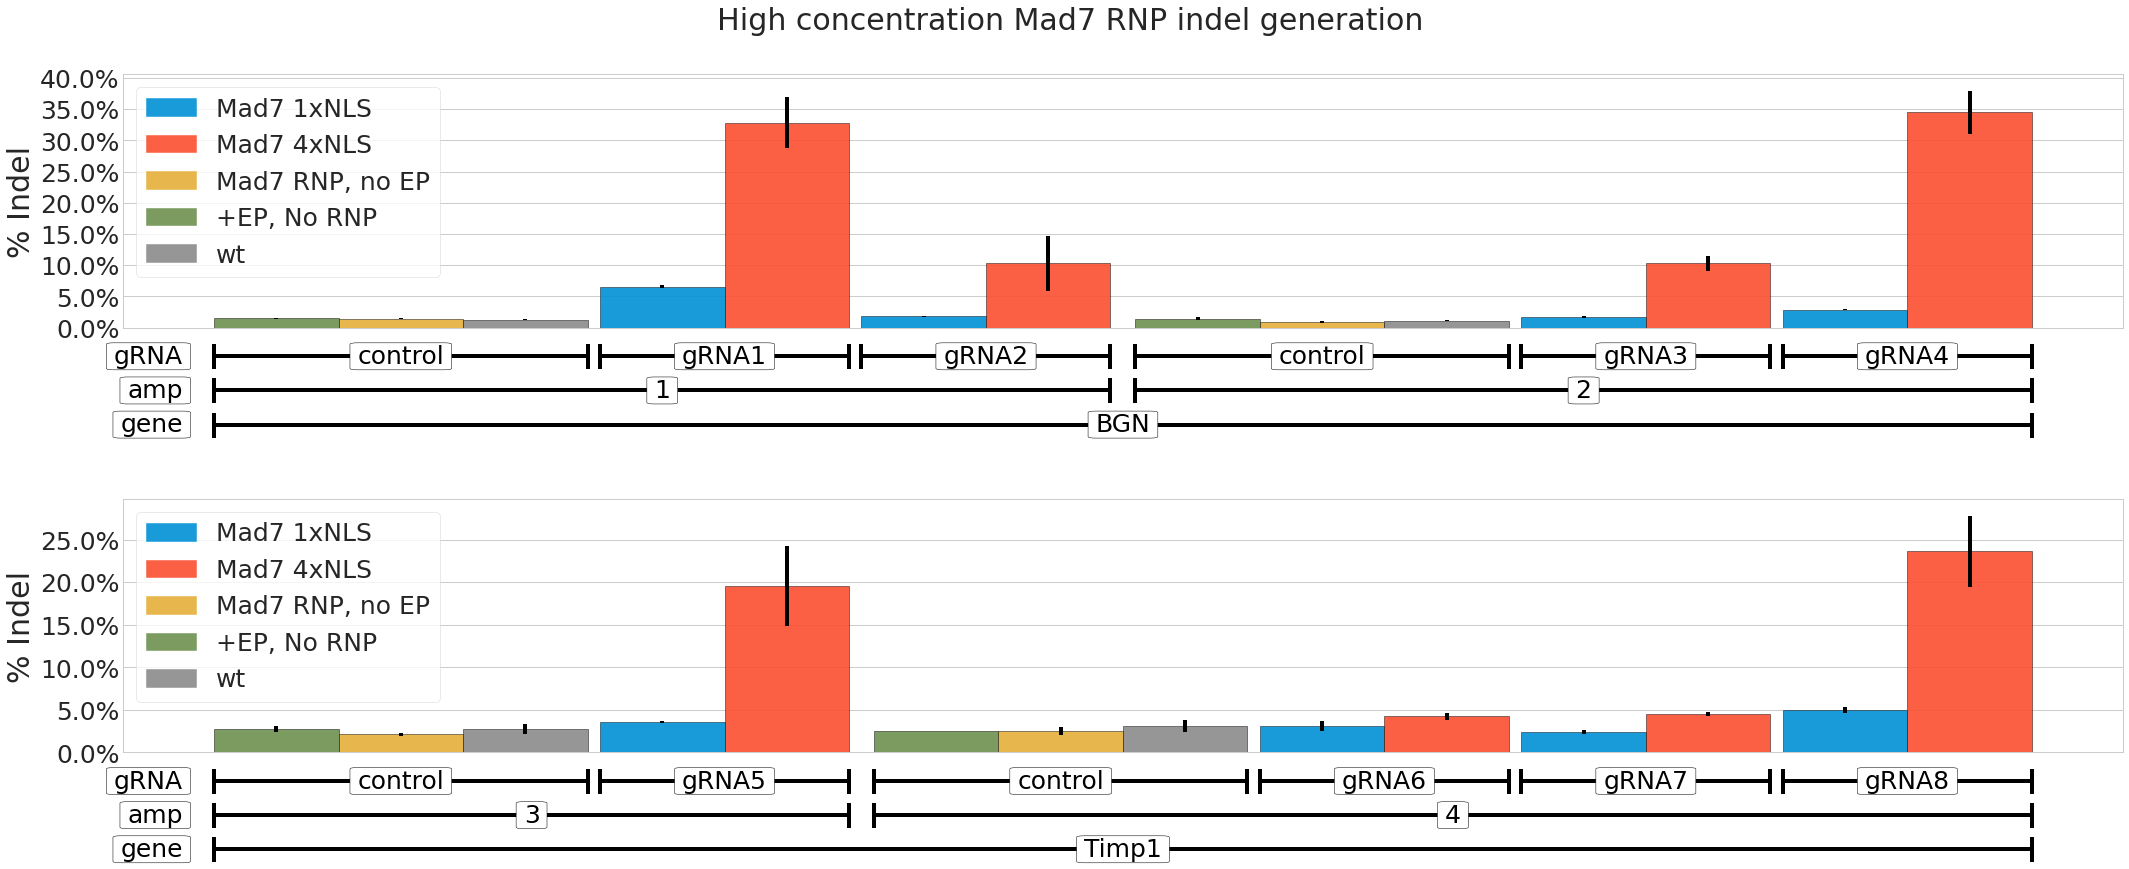

In [229]:
with plt.style.context(["fivethirtyeight", "seaborn-whitegrid",], ):
    plt.rcParams.update({'font.size':25})
    f, axs = plt.subplots(2, 1, figsize=(30,13))
    axa = multi_group_bar_chart(df[(df.amp.isin([1, 2]) & (df.RNP) & (df.enzyme!='Cas9') & (df.conc!='low') & (df.cell=='CHO-S'))], ['gene', 'amp', 'gRNA', 'CRISPR'], '%Indel', color_dict=hard_coded_colors, ax=axs[0])
    axb = multi_group_bar_chart(df[(df.amp.isin([3, 4]) & (df.RNP) & (df.enzyme!='Cas9') & (df.conc!='low') & (df.cell=='CHO-S'))], ['gene', 'amp', 'gRNA', 'CRISPR'], '%Indel', color_dict=hard_coded_colors, ax=axs[1])
    f.suptitle("High concentration Mad7 RNP indel generation")
    plt.tight_layout()
    f.savefig("figs/fig1.svg", facecolor='w', bbox_inches="tight")
#with plt.style.context(["fivethirtyeight", "seaborn-whitegrid",], ):     
#    ax = multi_group_bar_chart(df[(df.amp.isin([1, 2, 3, 4]) & (df.RNP) & (df.enzyme!='Cas9') & (df.conc!='low') & (df.cell=='CHO-S'))], ['gene', 'amp', 'gRNA', 'CRISPR'], '%Indel', color_dict=hard_coded_colors)

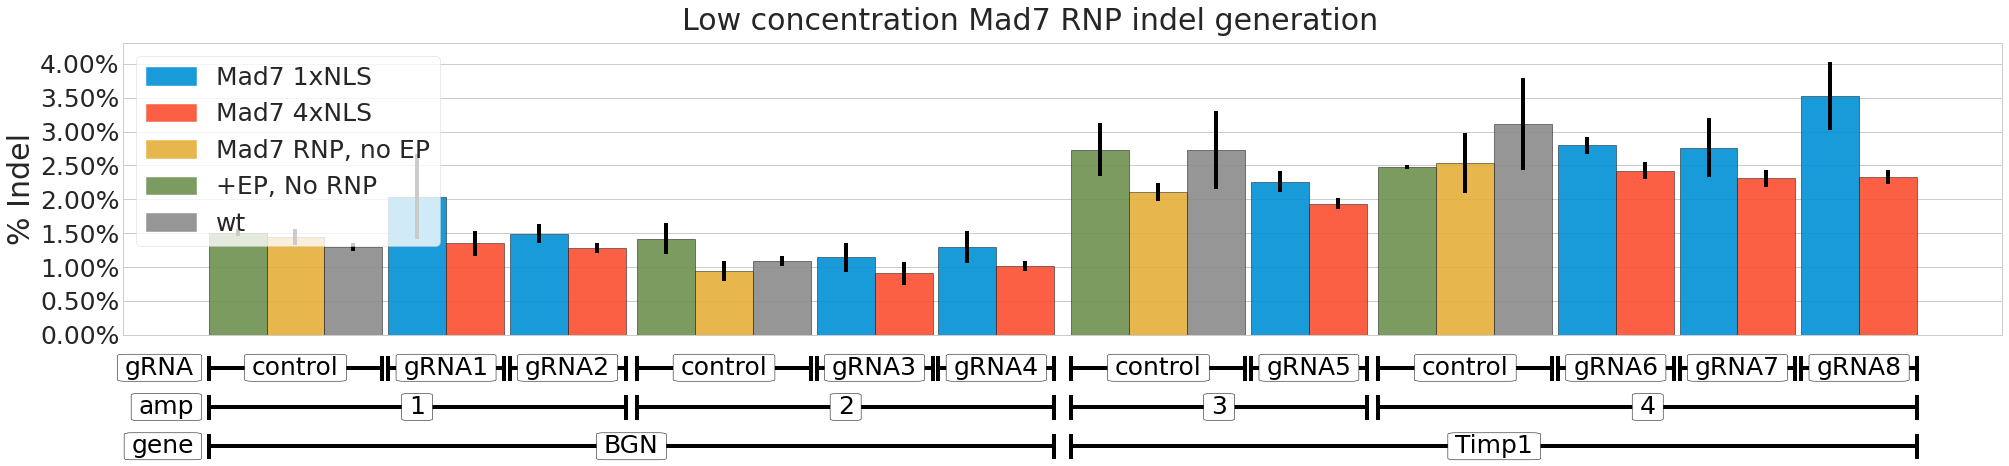

In [230]:
with plt.style.context(["fivethirtyeight", "seaborn-whitegrid",], ):     
    plt.rcParams.update({'font.size':25})
    ax = multi_group_bar_chart(df[(df.amp.isin([1, 2, 3, 4]) & (df.RNP) & (df.enzyme!='Cas9') & (df.conc!='high') & (df.cell=='CHO-S'))], ['gene', 'amp', 'gRNA', 'CRISPR'], '%Indel', color_dict=hard_coded_colors)
    plt.gcf().suptitle("Low concentration Mad7 RNP indel generation")
    plt.gcf().savefig("figs/S1.svg", facecolor='w', bbox_inches="tight")

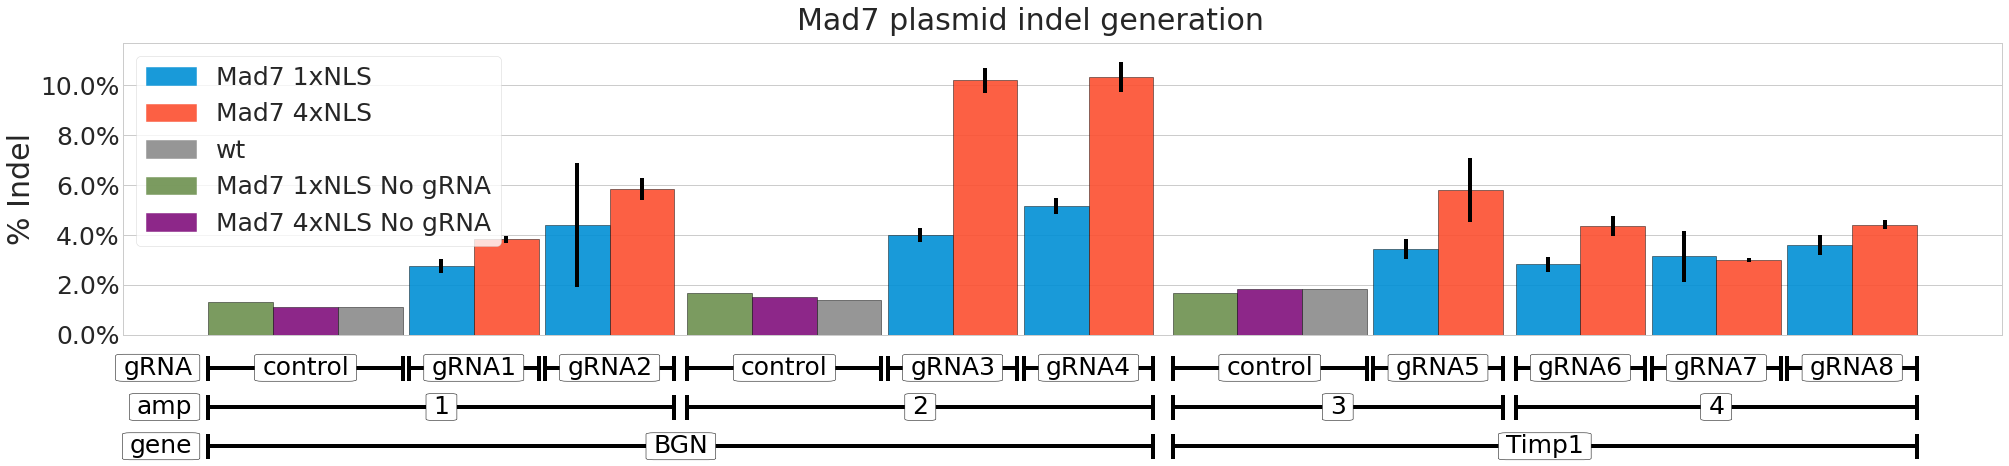

In [231]:
with plt.style.context(["fivethirtyeight", "seaborn-whitegrid",], ):
    plt.rcParams.update({'font.size':25})
    ax = multi_group_bar_chart(df[~df.RNP], ['gene', 'amp', 'gRNA', 'CRISPR'], '%Indel', color_dict=hard_coded_colors)
    plt.gcf().suptitle("Mad7 plasmid indel generation")
    plt.gcf().savefig("figs/fig2.svg", facecolor='w', bbox_inches="tight")

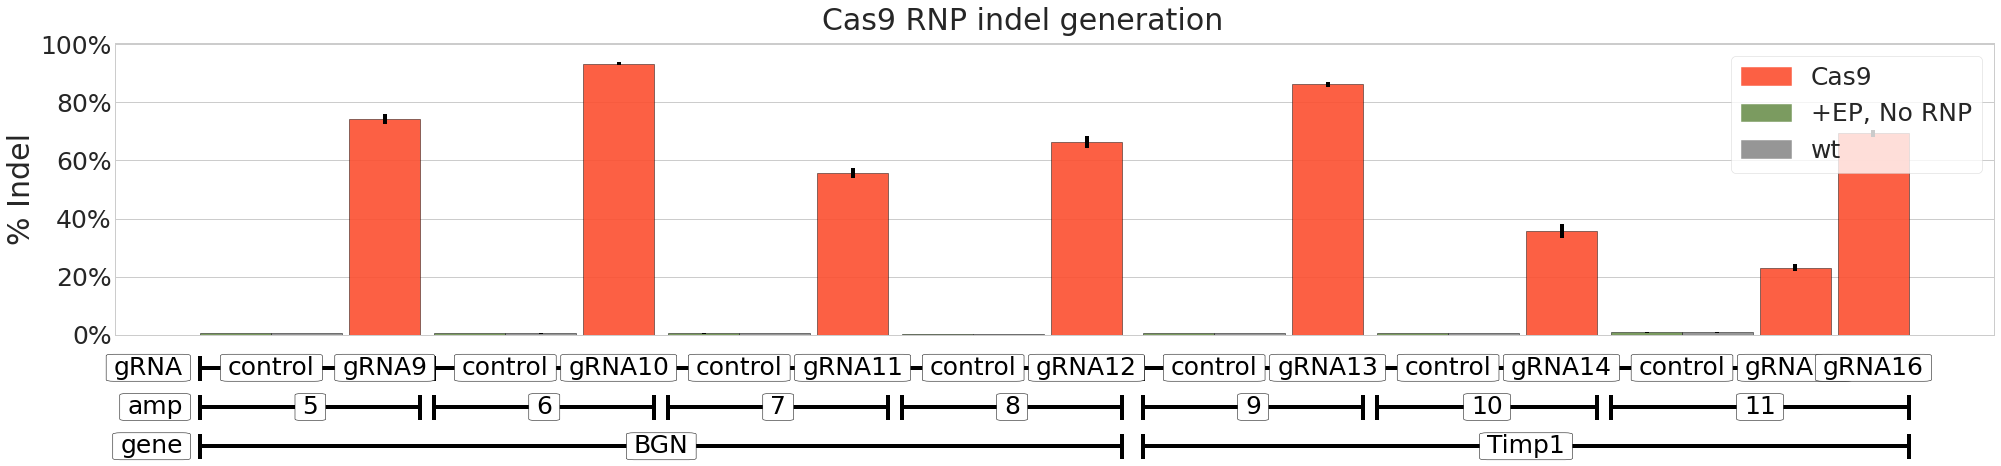

In [232]:
with plt.style.context(["fivethirtyeight", "seaborn-whitegrid",], ):
    plt.rcParams.update({'font.size':25})
    ax = multi_group_bar_chart(df[(df.amp.isin([5, 6, 7, 8, 9, 10, 11])) & (df.enzyme!='Mad7') & (df.cell=='CHO-S')], ['gene','amp', 'gRNA', 'CRISPR'], '%Indel', color_dict=hard_coded_colors)
    plt.gcf().suptitle("Cas9 RNP indel generation")
    plt.gcf().savefig("figs/S2.svg", facecolor='w', bbox_inches="tight")